In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import itertools as iter
import math
from sklearn.preprocessing import MinMaxScaler
import moo_functions as moo
from moo_functions import evaluate_solution_metrics
import plotly.express as px
import plotly.graph_objects as go

import random
from math import inf
from tqdm import tqdm

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions


# Part 2: MOO Algorithms
**Generating the Pareto Front**  
Instead of taking all solutions -> reducing to a Pareto front, we want to sort of "run along" the Pareto front, generating it whilst bypassing as many of the bad solutions as possible to reduce compute time. One way to achieve this is with evolutionary algorithms.

### Evolutionary algorithms  
Evolutionary computation refers to a family (haha) of algorithms that deploy optimization techniques inspired by natural processes like reproduction and selection. This includes processes like genetic algorithms, evolutionary programming, evolution strategies, swarm intelligence, and more. \
No matter the particular algorithm, the general principle of evolutionary computation is like so: every solution (here called "individuals") are encoded as decision vectors (e.g. bringing top 1?: yes, bringing top 2?: no) are evaluated using a fitness function(s), and placed by the algorithm in a "population" of individuals that evolve over time through processes analogous to biological reproduction and mutation. \
For example, in nature a population of butterflies in a particular section of forest will evolve over years as years as the most "optimal" butterflies (e.g. wings good shape to fly? yes, wings camouflage decently? yes) survive and reproduce, and random mutations that may improve odds also occur (like being born with spots on wings that kind of look like predator eyes), resulting in a group of fast-flying, well-defended butterflies. \
\
How can this help with our case? \
If butterflies never had any predators or food/mate scarcity, you would be left with billions of billions of (mostly not well-suited for life) bugs - too many butterflies! We had this with our case, with too many individuals (potential suitcases), most of which we know are not Pareto Optimized, and too little resources. What we can do is use an evolutionary algorithm where the "ancestor" is the full suitcase, which has no outfit or liking loss but lots of volume, and it can produce offspring that mutates and crosses-over with eachother to find the best solution between all three. This process should hypothetically iterate through the true Pareto front, as the only offspring that survive are indeed the best.  
We'll take a look at some of most popular MOEAs.

In [2]:
tops_df = pd.read_csv("tops", index_col=False)
bottoms_df = pd.read_csv("bottoms", index_col=False)

tops_dict = tops_df.to_dict(orient='records')
bottoms_dict = bottoms_df.to_dict(orient='records')

num_tops = len(tops_dict)
num_bottoms = len(bottoms_dict)
all_clothes_list = tops_dict + bottoms_dict

objectives = ["outfits_lost", "volume", "liking_diff"]
full_pareto_front_df = pd.read_csv("full_pareto_front_df")
all_objs = pd.DataFrame(np.load('all_solns.npy'), columns=objectives)
vis_subset = all_objs.sample(frac=0.05, random_state=42) # subset for smooth visualization

num_items = num_tops+num_bottoms
full_suitcase_metrics = evaluate_solution_metrics(np.ones(num_items), num_tops, num_bottoms, all_clothes_list)
num_objectives = len(full_suitcase_metrics)

In [3]:
# The library pymoo will assist us with some the algorithms that would be lengthly to define locally, namely SMS-EMOA, CMOPSO, and MOPSO-CD
# which uses a "problem" class that defines the solution space, in this case a 20 (number of clothing items) length array of 0/1s (you either
# pack the item or you don't, which is turned into our three objective tuple with evaluate_solution_metrics()

class BinaryProblem(ElementwiseProblem):

    def __init__(self, n_var, n_obj):
        super().__init__(
            n_var=20,
            n_obj=3,
            xl=0.0,
            xu=1.0,
            #elementwise_evaluation=True
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # binary projection
        x_bin = (x > 0.5).astype(int)

        # eval objectives
        objs = moo.evaluate_solution_metrics(x_bin, num_tops, num_bottoms, all_clothes_list)

        out["F"] = [objs]
        
problem = BinaryProblem(n_var=num_items, n_obj=num_objectives)
sampling = BinaryRandomSampling()
crossover = TwoPointCrossover(prob=0.9)
mutation = BitflipMutation(prob=0.02)


## NSGA-II

In [4]:
import nsga2
start_time = time.time()
nsga_sols, nsga_objs = nsga2.run(
    evaluate_solution_metrics,
    num_tops=num_tops,
    num_bottoms=num_bottoms,
    all_clothes_list=all_clothes_list,
    n_bits=num_items,
    pop_size=len(full_pareto_front_df),
    generations=250,
    #generations=10,
    mutation_rate=2/100
)
end_time = time.time()
nsga_time = end_time - start_time

Processing items: 100%|██████████████████████████████████████████████████████████████| 250/250 [01:34<00:00,  2.66it/s]


In [5]:
nsga_df = pd.DataFrame(nsga_objs, columns=objectives)
nsga_df.name = "NSGA-II"

nsga_paretos = pd.merge(nsga_df, full_pareto_front_df, on=objectives, how='inner').drop_duplicates()
nsga_paretos.name = "NSGA-II"

## MOEA/D

In [6]:
import moead
start_time = time.time()
moead_final_pop = moead.MOEAD(
    n_vars=num_items,
    n_objectives=num_objectives,
    num_tops=num_tops,
    num_bottoms=num_bottoms,
    all_clothes_list=all_clothes_list,
    population_size=len(full_pareto_front_df),
    max_generations=250,
    #max_generations=10,
    neighborhood_size=30
)
moead_sols, moead_objs = moead_final_pop.run()
end_time = time.time()
moead_time = end_time - start_time

Processing items: 100%|██████████████████████████████████████████████████████████████| 250/250 [00:30<00:00,  8.14it/s]


In [7]:
moead_df = pd.DataFrame(moead_objs, columns=objectives)
moead_df.name = "MOEA/D"

moead_paretos = pd.merge(moead_df, full_pareto_front_df, on=objectives, how='inner').drop_duplicates()
moead_paretos.name = "MOEA/D"

## SMS-EMOA

In [8]:
from pymoo.algorithms.moo.sms import SMSEMOA

algorithm = SMSEMOA(pop_size=196, sampling=sampling, crossover=crossover, mutation=mutation)

start_time = time.time()
res_sms = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)
end_time = time.time()
sms_time = end_time - start_time

In [9]:
sms_emoa_df = pd.DataFrame(res_sms.F, columns=objectives)
sms_emoa_df.name = "SMS-EMOA"

sms_emoa_paretos = pd.merge(sms_emoa_df, full_pareto_front_df, on=objectives, how='inner').drop_duplicates()
sms_emoa_paretos.name = "SMS EMOA-PyMOO"

## SPEA2

In [10]:
import spea2
start_time = time.time()
spea_sols, spea_objs = spea2.run(
    n_bits=num_items,
    num_tops=num_tops,
    num_bottoms=num_bottoms,
    all_clothes_list=all_clothes_list,
    population_size=len(full_pareto_front_df),
    archive_size=len(full_pareto_front_df),
    generations=100,
    mutation_rate=0.02
)
end_time = time.time()
spea_time = end_time - start_time

Processing items: 100%|██████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]


In [11]:
spea_df = pd.DataFrame(spea_objs, columns=objectives)
spea_df.name = "SPEA2"

spea_paretos = pd.merge(spea_df, full_pareto_front_df, on=objectives, how='inner').drop_duplicates()
spea_paretos.name = "SPEA2"

### Swarm Intelligence
SI is similar to EA, but instead models the collective behavior of decentralized, self-organized systems (e.g. bird flocks, ant colonies) to solve  optimization problems through local interactions. It emphasizes cooperation among agents in real-time, the "solution" is often emergent from immediate, repeated interactions, and opposed to EA which, of course, mimics evolution over generations. Particle Swarm Optimization (PSO) models bird flocking, where particles move through a search space, adjusting their positions based on their own best experience and the group's best experience. Hybrid systems like CMOPSO or MOPSO-CD combine them, implementing both crossover and PSO-style velocity updates.

## CMOPSO

In [12]:
from pymoo.algorithms.moo.cmopso import CMOPSO

algorithm = CMOPSO(
    pop_size=196,
    archive_size=100,
    w=0.4,          # inertia
    c1=1.5,         # cognitive
    c2=1.5,         # social
    max_velocity_rate=0.2
)

start_time = time.time()
res_cmopso = minimize(
    problem,
    algorithm,
    termination=("n_gen", 200),
    seed=1,
    verbose=False
)
end_time = time.time()
cmopso_time = end_time - start_time

C:\Users\zizzi\anaconda3\envs\py311\Lib\site-packages\pymoo\operators\mutation\pm.py:52: RuntimeWarning: invalid value encountered in power
  d = 1.0 - (np.power(val, mut_pow))
C:\Users\zizzi\anaconda3\envs\py311\Lib\site-packages\pymoo\operators\mutation\pm.py:47: RuntimeWarning: invalid value encountered in power
  d = np.power(val, mut_pow) - 1.0


In [13]:
pymoo_df = pd.DataFrame(res_cmopso.F, columns=objectives)
cmopso_paretos = pd.merge(pymoo_df, full_pareto_front_df, on=objectives, how='inner').drop_duplicates()
cmopso_paretos.name = "CMOPSO"

## MOPSO-CD

In [14]:
from pymoo.algorithms.moo.mopso_cd import MOPSO_CD

algorithm = MOPSO_CD(
    pop_size=196,
    w=0.6,
    c1=2.0,
    c2=2.0,
    max_velocity_rate=0.5,
    archive_size=100,
    seed=1
)

start_time = time.time()
res_mopso = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)
end_time = time.time()
mopso_time = end_time - start_time

In [15]:
pymoo_df = pd.DataFrame(res_mopso.F, columns=objectives)
mopso_paretos = pd.merge(pymoo_df, full_pareto_front_df, on=objectives, how='inner').drop_duplicates()
mopso_paretos.name = "MOPSO-CD"

## All algorithms comparison  
Let's see how all these algorithms stack up to eachother.

Visualizing the points they captured (green = algorithm found, blue = algorithm didn't find):

In [16]:
def algo_comp_plot(data):
    
    plt.figure(figsize=(7, 3.5))
    plt.title(data.name)
    
    plt.subplot(1,3,1)
    plt.scatter(data=vis_subset, x="outfits_lost", y="volume",color='pink', alpha=0.1)
    plt.scatter(data=full_pareto_front_df, x="outfits_lost", y="volume",color='blue', alpha=0.1)
    plt.scatter(data=data, x="outfits_lost", y="volume", c="liking_diff", cmap='Greens')
    plt.xlabel("outfits_lost")
    plt.ylabel("volume")
    
    plt.subplot(1,3,2)
    plt.scatter(data=vis_subset, x="liking_diff", y="volume", color='pink', alpha=0.1)
    plt.scatter(data=full_pareto_front_df, x="liking_diff", y="volume", color='blue', alpha=0.1)
    plt.scatter(data=data, x="liking_diff", y="volume", c="outfits_lost", cmap='Greens')
    plt.xlabel("liking_diffs")
    plt.ylabel("volume")
    
    plt.subplot(1,3,3)
    plt.scatter(data=vis_subset, x="outfits_lost", y="liking_diff", color='pink', alpha=0.1)
    plt.scatter(data=full_pareto_front_df, x="outfits_lost", y="liking_diff", color='blue', alpha=0.1)
    plt.scatter(data=data, x="outfits_lost", y="liking_diff", c="volume", cmap='Greens')
    plt.xlabel("outfits_lost")
    plt.ylabel("liking_diffs")

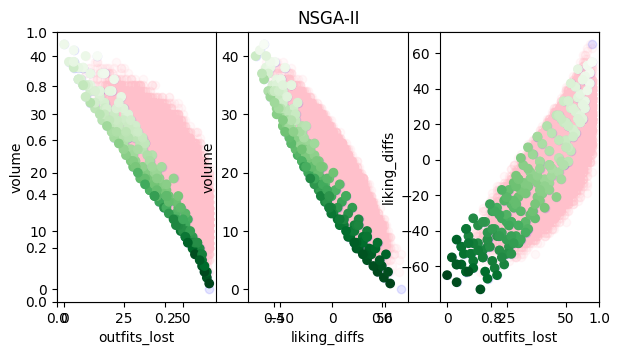

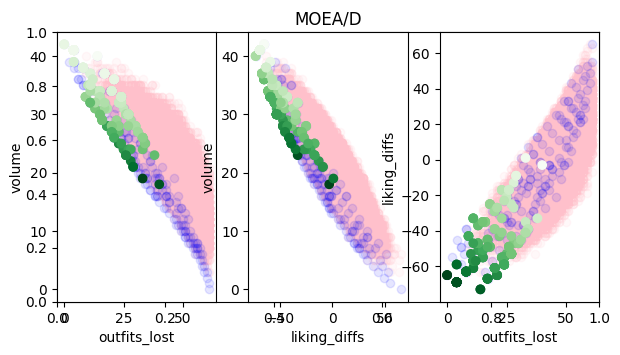

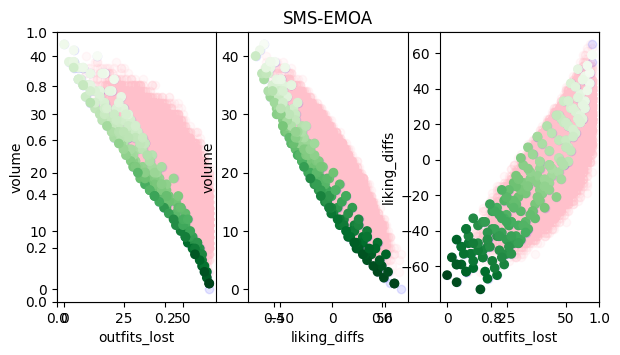

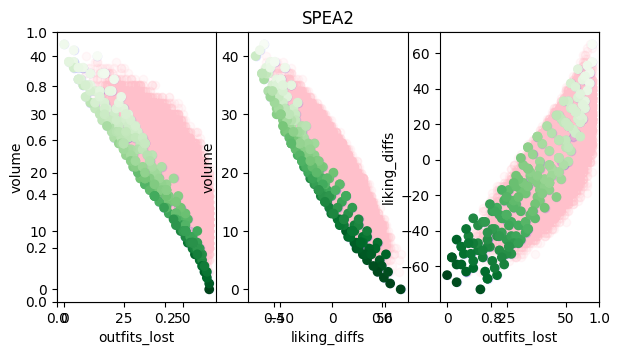

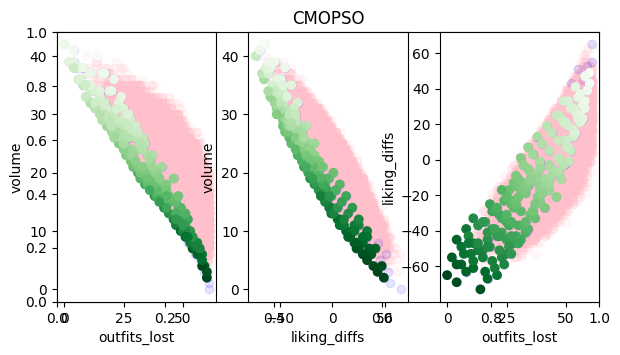

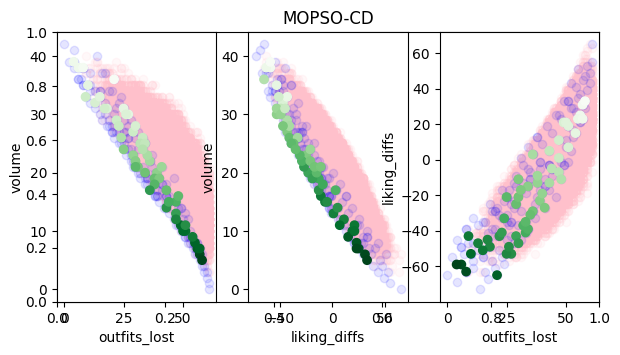

In [17]:
for df in [nsga_df, moead_df, sms_emoa_df, spea_df, cmopso_paretos, mopso_paretos]:
    algo_comp_plot(df)

Looking at numerical metrics:

In [18]:
algorithm_names = ["NSGA-II", "MOEA/D", "SMS EMOA", "SPEA 2", "CMOPSO", "MOPSO-CD"]
num_paretos = [len(nsga_paretos), len(moead_paretos), len(sms_emoa_paretos), len(spea_paretos), len(cmopso_paretos), len(mopso_paretos)]
times_to_complete = [nsga_time, moead_time, sms_time, spea_time, cmopso_time, mopso_time]
pd.DataFrame({"Algorithm":algorithm_names, "# of True Pareto Optimal Points Retreived":num_paretos, "Time to complete each algorithm (s)":times_to_complete})

,Algorithm,# of True Pareto Optimal Points Retreived,Time to complete each algorithm (s)
0,NSGA-II,162,94.044862
1,MOEA/D,51,30.732069
2,SMS EMOA,161,13.857106
3,SPEA 2,159,358.803725
4,CMOPSO,157,23.852370
5,MOPSO-CD,53,24.249378


Picking a "best" algorithm is seemingly a whole other MOO problem itself! To simply things, I'll go with SMS EMOA, since it runs for a fraction of the time of NSGA-II and only misses a few points.

In [19]:
sms_emoa_paretos.to_csv("best_algo_solns.csv", index=False)

In Part 3, we'll use decision making methods to further narrow down this list of solutions.